In [1]:
#import required libraries
import sqlite3
import pandas as pd
from google.colab import drive
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns

#mount Google Drive
drive.mount('/content/drive')
csv_path = "/content/drive/MyDrive/Applied_Data_Science/WorldDevelopmentIndicatorsData.csv"
db_path = "/content/drive/MyDrive/Applied_Data_Science/factbook.db"

Mounted at /content/drive


In [2]:
#connect to the Factbook database
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

#fetch the tables names
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

if not tables:
    print("No tables found in the database.")
else:
    print("Tables in the database:")

    for table in tables:
        table_name = table[0]
        print(f"\nTable: {table_name}")

        #fetch column info and attributes
        cursor.execute(f'PRAGMA table_info("{table_name}");')
        columns = cursor.fetchall()

        #print the tables, the columns and their attributes
        headers = ["Column ID", "Name", "Type", "NotNull", "Default Value", "Primary Key"]
        table_data = [[col[0], col[1], col[2], col[3], col[4], col[5]] for col in columns]
        print(tabulate(table_data, headers=headers, tablefmt="grid"))

Tables in the database:

Table: facts
+-------------+-------------------+--------------+-----------+-----------------+---------------+
|   Column ID | Name              | Type         |   NotNull | Default Value   |   Primary Key |
+=============+===================+==============+===========+=================+===============+
|           0 | id                | INTEGER      |         1 |                 |             1 |
+-------------+-------------------+--------------+-----------+-----------------+---------------+
|           1 | code              | varchar(255) |         1 |                 |             0 |
+-------------+-------------------+--------------+-----------+-----------------+---------------+
|           2 | name              | varchar(255) |         1 |                 |             0 |
+-------------+-------------------+--------------+-----------+-----------------+---------------+
|           3 | area              | INTEGER      |         0 |                 |         

In [10]:
#query to print entire table
query_all = """ SELECT * FROM facts; """
all = pd.read_sql_query(query_all, conn)
all.set_index('id', inplace=True)
print("Facts Table")
print(tabulate(all, headers='keys', tablefmt='grid'))

Facts Table
+------+--------+-----------------------------------------------+------------------+------------------+--------------+------------------+---------------------+--------------+--------------+------------------+----------------------------+----------------------------+
|   id | code   | name                                          |             area |        area_land |   area_water |       population |   population_growth |   birth_rate |   death_rate |   migration_rate | created_at                 | updated_at                 |
+======+========+===============================================+==================+==================+==============+==================+=====================+==============+==============+==================+============================+============================+
|    1 | af     | Afghanistan                                   | 652230           | 652230           |            0 |      3.25643e+07 |                2.32 |        38.57 |        13.89

In [4]:
#query to sort by population growth, birth, death and migration rates
query_orders = """ SELECT name, population, population_growth, birth_rate, death_rate, migration_rate
                      FROM facts ORDER BY population_growth DESC, birth_rate DESC, death_rate ASC,
                      migration_rate DESC; """

orders_date = pd.read_sql_query(query_orders, conn)
orders_date_cleaned = orders_date.dropna() #delete rows with empty cells
print("Sorted Facts Table")
print(tabulate(orders_date_cleaned, headers='keys', tablefmt='grid'))

Sorted Facts Table
+-----+-----------------------------------------------+------------------+---------------------+--------------+--------------+------------------+
|     | name                                          |       population |   population_growth |   birth_rate |   death_rate |   migration_rate |
+=====+===============================================+==================+=====================+==============+==============+==================+
|   0 | South Sudan                                   |      1.20429e+07 |                4.02 |        36.91 |         8.18 |            11.47 |
+-----+-----------------------------------------------+------------------+---------------------+--------------+--------------+------------------+
|   1 | Malawi                                        |      1.79647e+07 |                3.32 |        41.56 |         8.41 |             0    |
+-----+-----------------------------------------------+------------------+---------------------+---------

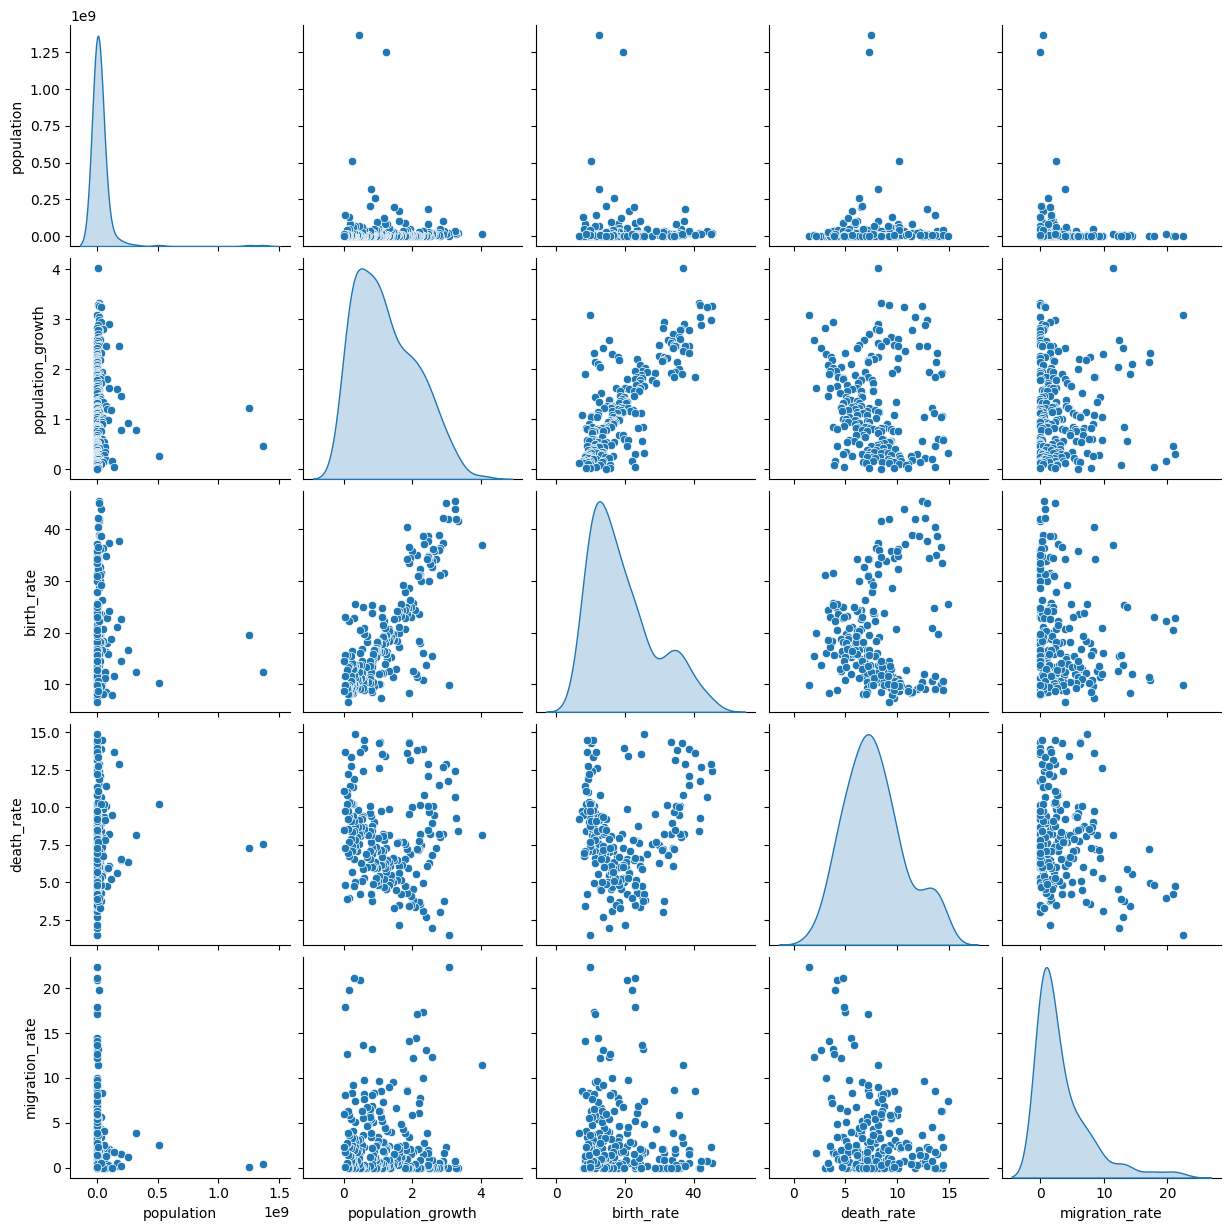

In [5]:
#generate pairplot
sns.pairplot(orders_date_cleaned, vars=['population', 'population_growth', 'birth_rate', 'death_rate', 'migration_rate'], diag_kind='kde')
plt.show()

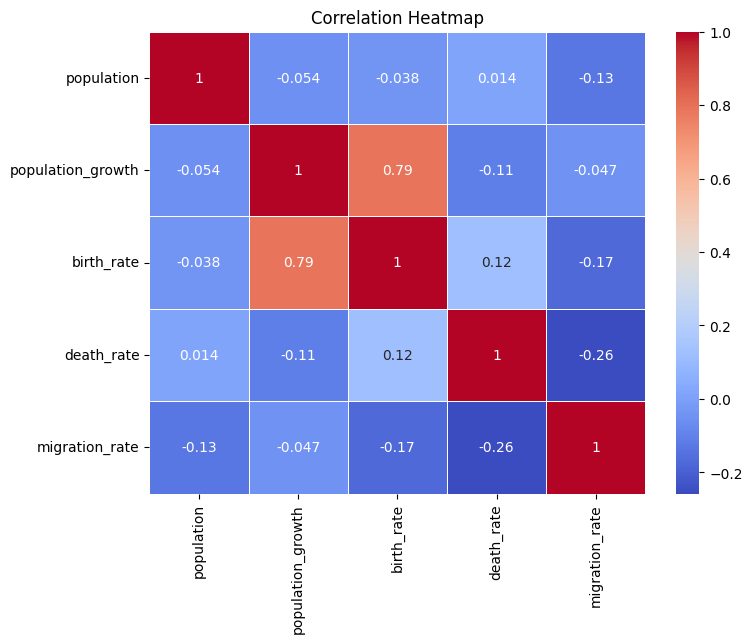

In [6]:
#calculate correlation matrix
correlation_matrix = orders_date_cleaned[['population', 'population_growth', 'birth_rate', 'death_rate', 'migration_rate']].corr()

#create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

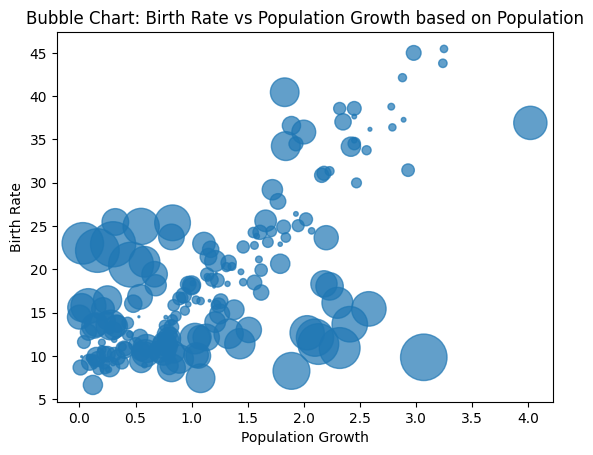

In [7]:
#bubble chart with size based on population
plt.scatter(orders_date_cleaned['population_growth'], orders_date_cleaned['birth_rate'], s=orders_date_cleaned['migration_rate'] * 50, alpha=0.7)
plt.xlabel("Population Growth")
plt.ylabel("Birth Rate")
plt.title("Bubble Chart: Birth Rate vs Population Growth based on Population")
plt.show()

In [8]:
#connect to the WDI CSV file
wdi = pd.read_csv(csv_path)
wdi_head = wdi.head()
print(tabulate(wdi_head, headers='keys', tablefmt='grid'))

+----+----------------+----------------+----------------------------------------------------------------+----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+
|    | Country Name   | Country Code   | Series Name                                                    | Series Code    |   2013 [YR2013] |   2014 [YR2014] |   2015 [YR2015] |   2016 [YR2016] |   2017 [YR2017] |   2018 [YR2018] |   2019 [YR2019] |   2020 [YR2020] | 2021 [YR2021]    | 2022 [YR2022]    |
+====+================+================+================================================================+================+=================+=================+=================+=================+=================+=================+=================+=================+==================+==================+
|  0 | Argentina      | ARG            | Adolescent fertility rate (births per 1,000 

In [11]:
#overwrite the existing csv file in the factbook db with the wdi csv
wdi.to_sql('CSVFILE', conn, if_exists='replace', index=False)

query_merge = """ SELECT f.id AS country_id, COALESCE(c.'Country Code', f.code) AS country_code, COALESCE(f.name, c.'Country Name') AS country,
                  f.area, f.area_land, f.area_water, f.population, f.population_growth AS growth_rate,
                  f.birth_rate, f.death_rate, f.migration_rate, c.'Series Name' AS series_name, c.'Series Code' AS series_code,
                  c.'2013 [YR2013]' AS	'2013', c.'2014 [YR2014]' AS	'2014',	c.'2015 [YR2015]' AS	'2015',	c.'2016 [YR2016]' AS	'2016',
                  c.'2017 [YR2017]' AS	'2017', c.'2018 [YR2018]' AS	'2018',	c.'2019 [YR2019]' AS	'2019',	c.'2020 [YR2020]' AS	'2020',
                  c.'2021 [YR2021]' AS	'2021', c.'2022 [YR2022]' AS	'2022' FROM facts AS f INNER JOIN CSVFILE AS c ON f.name = c.'Country Name'; """
merge = pd.read_sql_query(query_merge, conn)
merge.set_index('country_id', inplace=True)
print("Merged Table")
merge_head = merge.head(25)
print(tabulate(merge_head, headers='keys', tablefmt='grid'))

Merged Table
+--------------+----------------+-------------+--------+-------------+--------------+--------------+---------------+--------------+--------------+------------------+----------------------------------------------------------------------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------+
|   country_id | country_code   | country     |   area |   area_land |   area_water |   population |   growth_rate |   birth_rate |   death_rate |   migration_rate | series_name                                                          | series_code       | 2013             | 2014              | 2015              | 2016              | 2017              | 2018              | 2019              | 2020              | 2021              | 2022   |
+==============+================+=============+========+=============+==============+============